# Depth Estimation and Segmentation

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

import os,sys
# Manually specify the path to the project directory
project_path = '../../'

# Add the project directory to sys.path
sys.path.append(project_path)
from mansoor import Repeatable

os.makedirs('../output', exist_ok=True)

In [4]:
r = Repeatable(base_path='../../data/images/')

<h3>Depth Estimation</h3>
Depth estimation is the process of figuring out how far away objects are in an image or video. Imagine looking at a photo of a street; depth estimation helps you figure out which objects are closer to you (like a car) and which ones are farther away (like buildings). Computers do this by analyzing the image and looking for clues like object size, shadow, or how things overlap. It's like how you can tell if something is near or far when you look at it with your eyes.

<h3>Segmentation</h3>
Segmentation is like cutting up an image into smaller parts based on similarities. In computer vision, this means dividing an image into different regions so that the computer can understand what's in the image, like identifying people, cars, trees, or buildings separately. You could think of it like coloring in different parts of a drawing—each section has its own color (or label) to show what’s what.

<div style="text-align: center;">
    <img src="../../data/images/segmentation_example.png" width="500" height="300" alt="Segmentation Example">
</div>


So in simple terms:
- **Depth Estimation**: Finding out how far or close things are in a picture.
- **Segmentation**: Breaking a picture into parts to understand what’s in it.

These two techniques help computers “see” and understand the world, like how we do with our eyes!

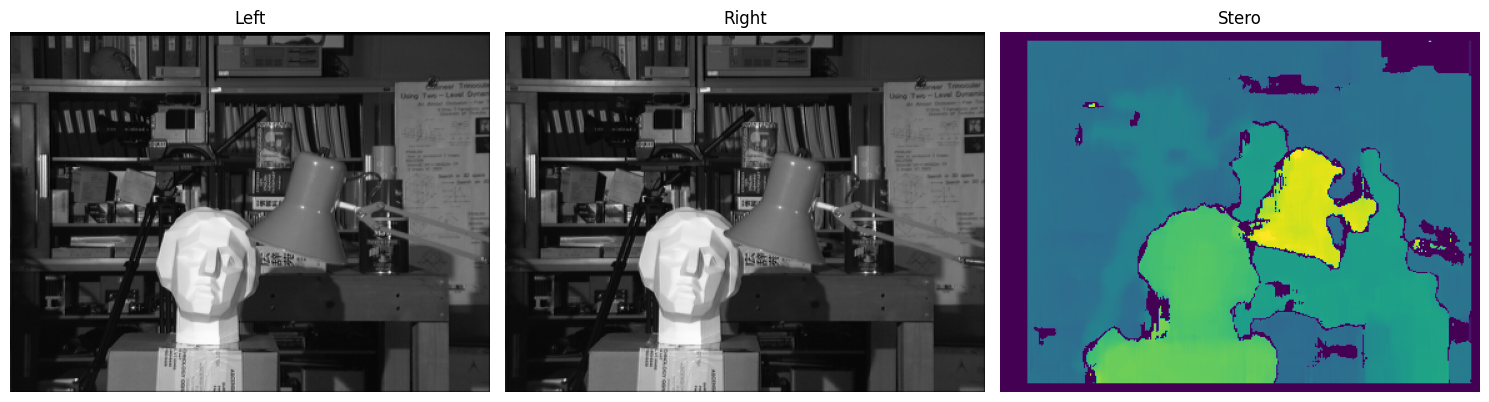

In [5]:
imgL = r.load_image('tsukuba_l.png', 0)
imgR = r.load_image('tsukuba_r.png', 0)
 
stereo = cv2.StereoBM.create(numDisparities=16, blockSize=15)
disparity = stereo.compute(imgL,imgR)

r.show_multiple_images((imgL, imgR, disparity), titles=("Left","Right","Stero"))

## Creating a mask from a disparity map

In [6]:
def createMedianMask(disparityMap, validDepthMask, rect=None):
    if rect is not None:
        x, y, w, h = rect
        disparityMap = disparityMap[y:y + h, x:x + w]
        validDepthMask = validDepthMask[y:y + h, x:x + w]
    median = np.median(disparityMap[validDepthMask > 0])
    return np.where((validDepthMask > 0) & (np.abs(disparityMap - median) < 12), 1, 0)

#### Explanation of the `createMedianMask` function:

1. **Purpose**:  
   This function creates a binary mask that identifies pixels in a disparity map that are within a certain range of the median disparity value for valid depth data in a given region.

2. **Key Steps**:  
   - **Region Cropping (Optional)**:  
     If a rectangular region (`rect`) is provided, it extracts a subset of the `disparityMap` and `validDepthMask` for analysis.
   - **Median Calculation**:  
     It calculates the **median disparity value** from the disparity map for pixels marked as valid (`validDepthMask > 0`).
   - **Mask Creation**:  
     It generates a mask where pixels are marked as `1` (valid) if:  
       - They are part of the valid depth mask (`validDepthMask > 0`).  
       - Their disparity value is close to the median (within a threshold of `12`).  
     All other pixels are marked as `0`.

3. **Use Case**:  
   This function helps refine the estimated facial region in disparity maps by excluding outliers:
   - Pixels too close or too far from the median are excluded.  
   - Only pixels with valid depth data are considered for analysis.  

This method is crucial when processing depth maps for tasks like facial region segmentation to enhance the accuracy of face tracking and recognition.

## Masking a copy operation

In [7]:
def copyRect(src, dst, srcRect, dstRect, mask=None, interpolation=cv2.INTER_LINEAR):
    x0, y0, w0, h0 = srcRect
    x1, y1, w1, h1 = dstRect
    if mask is None:
        dst[y1:y1 + h1, x1:x1 + w1] = cv2.resize(src[y0:y0 + h0, x0:x0 + w0], (w1, h1), interpolation=interpolation)
    else:
        if len(mask.shape) == 2:
            mask = np.repeat(mask[:, :, np.newaxis], 3, axis=2)
        resized_mask = cv2.resize(mask, (w1, h1), interpolation=cv2.INTER_NEAREST)
        resized_src = cv2.resize(src[y0:y0 + h0, x0:x0 + w0], (w1, h1), interpolation=interpolation)
        dst[y1:y1 + h1, x1:x1 + w1] = np.where(resized_mask > 0, resized_src, dst[y1:y1 + h1, x1:x1 + w1])

#### Explanation of the `copyRect` function:

1. **Purpose**:  
   The function copies a rectangular region from a source image (`src`) to a specified rectangular region in a destination image (`dst`). Optionally, it can apply a mask to control which parts of the source are copied.

2. **Parameters**:  
   - **`src`**: The source image.
   - **`dst`**: The destination image.
   - **`srcRect`**: A tuple `(x0, y0, w0, h0)` defining the rectangle in the source image to be copied.  
   - **`dstRect`**: A tuple `(x1, y1, w1, h1)` defining the rectangle in the destination image where the source will be copied.  
   - **`mask`** (optional): A binary mask controlling which pixels are copied (non-zero values in the mask mean the pixel will be copied).  
   - **`interpolation`**: Specifies the interpolation method for resizing (default: linear interpolation).

3. **Key Steps**:  
   - **Without Mask**:  
     - The source rectangle (`srcRect`) is resized to match the size of the destination rectangle (`dstRect`) using `cv2.resize`.  
     - The resized source region directly replaces the destination rectangle.
   - **With Mask**:  
     - The mask is resized to match the size of `dstRect` using nearest-neighbor interpolation (`cv2.INTER_NEAREST`).
     - The source rectangle is resized to match `dstRect`.  
     - The destination is updated using the mask:  
       - Pixels where the mask is non-zero are copied from the source.  
       - Pixels where the mask is zero remain unchanged in the destination.

4. **Use Case**:  
   - This function is useful in image processing tasks where specific regions of an image need to be copied, resized, and blended into another image.  
   - The optional mask allows selective copying, making it useful for tasks like compositing, object placement, or image editing.

In [8]:
def swapRects(src, dst, rects, masks = None,
              interpolation = cv2.INTER_LINEAR):
    """Copy the source with two or more sub-rectangles swapped."""
    
    if dst is not src:
        dst[:] = src
    
    numRects = len(rects)
    if numRects < 2:
        return
    
    if masks is None:
        masks = [None] * numRects
    
    # Copy the contents of the last rectangle into temporary storage.
    x, y, w, h = rects[numRects - 1]
    temp = src[y:y+h, x:x+w].copy()
    
    # Copy the contents of each rectangle into the next.
    i = numRects - 2
    while i >= 0:
        copyRect(src, dst, rects[i], rects[i+1], masks[i],
                 interpolation)
        i -= 1
    
    # Copy the temporarily stored content into the first rectangle.
    copyRect(temp, dst, (0, 0, w, h), rects[0], masks[numRects - 1],
             interpolation)

The `swapRects` function is designed to swap the contents of multiple rectangles (`rects`) within an image (`src`) and copy the swapped contents into a destination image (`dst`). It works as follows:

#### **Function Overview**
##### Parameters:
1. **`src`**: The source image (input).
2. **`dst`**: The destination image (output). If `dst` is the same as `src`, the changes are made in place.
3. **`rects`**: A list of rectangles (each defined as `(x, y, w, h)`) to be swapped.
4. **`masks`** (optional): A list of masks corresponding to the rectangles. Masks are binary images that define which parts of a rectangle are valid for copying.
   - If no masks are provided, the function defaults to copying all pixels in the rectangles.
5. **`interpolation`**: The interpolation method used for resizing when copying rectangles (default is `cv2.INTER_LINEAR`).

#### **How the Function Works**

1. **Check `dst` and Copy Entire Source if Needed**:
   ```python
   if dst is not src:
       dst[:] = src
   ```
   - If `dst` is different from `src`, the entire `src` image is copied to `dst`.

2. **Handle Cases with Fewer than Two Rectangles**:
   ```python
   numRects = len(rects)
   if numRects < 2:
       return
   ```
   - If there are fewer than two rectangles, there's nothing to swap, so the function returns early.

3. **Handle `masks`**:
   ```python
   if masks is None:
       masks = [None] * numRects
   ```
   - If no masks are provided, create a list of `None` values for the rectangles.

4. **Store the Last Rectangle Temporarily**:
   ```python
   x, y, w, h = rects[numRects - 1]
   temp = src[y:y+h, x:x+w].copy()
   ```
   - The contents of the last rectangle in `rects` are copied into a temporary variable (`temp`) to avoid overwriting when swapping.

5. **Iteratively Swap Rectangles in Reverse**:
   ```python
   i = numRects - 2
   while i >= 0:
       copyRect(src, dst, rects[i], rects[i+1], masks[i], interpolation)
       i -= 1
   ```
   - Starting from the second-to-last rectangle (`i = numRects - 2`), the contents of each rectangle are copied into the next one (`rects[i+1]`).
   - The `copyRect` function handles the actual rectangle copying, optionally applying a mask and interpolation.

6. **Copy the Temporarily Stored Rectangle into the First One**:
   ```python
   copyRect(temp, dst, (0, 0, w, h), rects[0], masks[numRects - 1], interpolation)
   ```
   - Finally, the contents of the last rectangle (stored in `temp`) are copied into the first rectangle in the list (`rects[0]`).

#### **Key Support Function: `copyRect`**
The `copyRect` function (used internally) is responsible for copying one rectangle from the source (`src`) to the destination (`dst`), potentially applying a mask and resizing the rectangle based on the `interpolation` parameter.

#### **Example Usage**
Suppose you have an image (`src`) and you want to swap the contents of two rectangles:

```python
rects = [(10, 10, 50, 50), (100, 100, 50, 50)]  # Two rectangles
swapRects(src, src, rects)
```
This will swap the regions `(10, 10, 50, 50)` and `(100, 100, 50, 50)` within the image in place.

#### **Purpose**
The function can be useful in image processing tasks, such as:
- Swapping face regions in an image for fun effects.
- Shuffling parts of an image.
- Rearranging content within a video frame.

## Depth Estimation with a Normal Camera

1. **Depth Cameras**:  
   - Devices like Microsoft Kinect use a traditional camera combined with an infrared sensor to estimate object distances.  
   - They calculate depth by differentiating surfaces and measuring distances.

2. **Challenge with Normal Cameras**:  
   - Depth cameras are expensive and not always accessible, especially for beginners.  
   - A regular camera (like a webcam or built-in camera) requires alternative techniques to estimate depth.

3. **Solution: Stereo Vision**:  
   - **Epipolar Geometry**: Uses two images of the same object taken from slightly different angles to estimate depth.  
   - Concept:  
     - Imaginary lines connect objects in both images to the camera.  
     - Intersection of these lines gives the object's distance.  

<div style="text-align: center;">
    <img src="../../data/images/concept.png" width="300" height="100" alt="Segmentation Example">
</div>

4. **Disparity Map with OpenCV**:  
   - Disparity maps represent the depth of objects in a scene.  
   - **Steps**:  
     1. Capture two images of the same object from different positions, maintaining equal distances.  
     2. Use OpenCV to calculate disparities (depth differences).  
     3. Extract foreground and discard the background.  

This method provides a basic way to perform depth estimation with a simple camera setup.

In [9]:
def update(val=0):
    # Update disparity calculation with trackbar values
    window_size = cv2.getTrackbarPos("Window size", "disparity")
    stereo.setBlockSize(window_size)
    stereo.setUniquenessRatio(cv2.getTrackbarPos("Uniqueness ratio", "disparity"))
    stereo.setSpeckleWindowSize(cv2.getTrackbarPos("Speckle window size", "disparity"))
    stereo.setSpeckleRange(cv2.getTrackbarPos("Speckle range", "disparity"))
    stereo.setDisp12MaxDiff(cv2.getTrackbarPos("Disp12 max diff", "disparity"))

    print("Computing disparity...")
    disp = stereo.compute(left_image, right_image).astype(np.float32) / 16.0
    cv2.imshow("Disparity", (disp - min_disp) / num_disp)

The `update()` function dynamically adjusts the stereo disparity map calculation using trackbars. Here's how it works:

1. **Trackbar Values**:  
   - Fetches values from trackbars for parameters like `Window size`, `Uniqueness ratio`, `Speckle window size`, `Speckle range`, and `Disp12 max diff`.

2. **Stereo Settings**:  
   - Updates the stereo block matcher (`stereo`) with the fetched parameters.

3. **Compute Disparity**:  
   - Computes the disparity map using the left and right images.
   - Normalizes and displays the disparity map in the "Disparity" window.

This function allows real-time tuning of disparity map parameters for better depth estimation.

In [10]:
# Stereo matching parameters
min_disp = 16
num_disp = 192 - min_disp
window_size = 5
block_size = window_size
uniqueness_ratio = 1
speckle_range = 3
speckle_window_size = 3
disp12_max_diff = 200

left_image = r.load_image('color1_small.jpg', 0)
right_image = r.load_image('color2_small.jpg', 0)
left_image = cv2.resize(left_image, (425,240))
# Set up StereoSGBM
stereo = cv2.StereoSGBM_create(minDisparity=min_disp,
                               numDisparities=num_disp,
                               blockSize=block_size,
                               uniquenessRatio=uniqueness_ratio,
                               speckleRange=speckle_range,
                               speckleWindowSize=speckle_window_size,
                               disp12MaxDiff=disp12_max_diff)

# Create trackbars for tuning disparity calculation
cv2.namedWindow("disparity")
cv2.createTrackbar("Speckle range", "disparity", speckle_range, 50, update)
cv2.createTrackbar("Window size", "disparity", window_size, 21, update)
cv2.createTrackbar("Speckle window size", "disparity", speckle_window_size, 200, update)
cv2.createTrackbar("Uniqueness ratio", "disparity", uniqueness_ratio, 50, update)
cv2.createTrackbar("Disp12 max diff", "disparity", disp12_max_diff, 250, update)

update()
cv2.waitKey(0)
cv2.destroyAllWindows()

error: OpenCV(4.10.0) D:\a\opencv-python\opencv-python\opencv\modules\highgui\src\window.cpp:868: error: (-215:Assertion failed) trackbar in function 'cv::getTrackbarPos'


error: OpenCV(4.10.0) D:\a\opencv-python\opencv-python\opencv\modules\highgui\src\window.cpp:868: error: (-215:Assertion failed) trackbar in function 'cv::getTrackbarPos'


error: OpenCV(4.10.0) D:\a\opencv-python\opencv-python\opencv\modules\highgui\src\window.cpp:868: error: (-215:Assertion failed) trackbar in function 'cv::getTrackbarPos'


error: OpenCV(4.10.0) D:\a\opencv-python\opencv-python\opencv\modules\highgui\src\window.cpp:868: error: (-215:Assertion failed) trackbar in function 'cv::getTrackbarPos'


Computing disparity...
Computing disparity...
Computing disparity...
Computing disparity...
Computing disparity...
Computing disparity...
Computing disparity...
Computing disparity...
Computing disparity...
Computing disparity...
Computing disparity...
Computing disparity...
Computing disparity...
Computing disparity...
Computing disparity...
Computing disparity...


This code implements stereo matching using OpenCV's `StereoSGBM` (Semi Global Block Matching) to compute a disparity map between two images. 

| Parameter              | Description                                                                                                                                                                                                                                                                                   |
|------------------------|------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| **minDisparity**        | Refers to the minimum possible disparity value. Normally 0, but sometimes rectification algorithms shift images, requiring adjustment.                                                                                                                                                           |
| **numDisparities**      | Refers to the maximum disparity minus the minimum disparity. The value must be greater than `minDisparity` and divisible by 16.                                                                                                                                                                 |
| **windowSize**          | Refers to the matched block size. It must be an odd number greater than or equal to 1, typically in the 3-11 range.                                                                                                                                                                            |
| **P1**                  | Controls disparity smoothness. The larger the value, the smoother the disparity. P1 is the penalty for a disparity change of plus or minus 1 between neighboring pixels.                                                                                                                                 |
| **P2**                  | Controls disparity smoothness. P2 is the penalty for disparity change of more than 1 between neighboring pixels. The algorithm requires `P2 > P1`.                                                                                                                                              |
| **disp12MaxDiff**       | Maximum allowed difference in the disparity check (in integer pixel units). Set it to a nonpositive value to disable the check.                                                                                                                                                               |
| **preFilterCap**        | Truncation value for prefiltered image pixels. The algorithm first computes a value at each pixel and clips it within the interval `[-preFilterCap, preFilterCap]`.                                                                                                                            |
| **uniquenessRatio**     | Refers to the margin by which the best (minimum) cost function value should "win" the second-best value to consider the match correct. Values in the 5-15 range are usually good enough.                                                                                                        |
| **speckleWindowSize**   | Maximum size of smooth disparity regions to filter out noise speckles. Set to 0 to disable speckle filtering. Typically set in the 50-200 range.                                                                                                                                               |
| **speckleRange**        | Maximum disparity variation within each connected component. When using speckle filtering, set to a positive value, which will be multiplied by 16. Usually, values like 1 or 2 work well.                                                                                                     |


## Object segmentation using the Watershed and GrabCut algorithms

Calculating a disparity map can be very useful to detect the foreground of an image, but StereoSGBM is not the only algorithm available to accomplish this, and in fact, StereoSGBM is more about gathering 3D information from 2D pictures than anything else. GrabCut, however, is a perfect tool for this purpose. The GrabCut algorithm follows a precise sequence of steps:

1. A rectangle including the subject(s) of the picture is defined.
2. The area lying outside the rectangle is automatically treated as background.
3. The data in the background is used as a reference to distinguish background areas from foreground areas within the rectangle.
4. A Gaussian Mixture Model (GMM) models the foreground and background and labels undefined pixels as probable background and foreground.
5. Each pixel in the image is virtually connected to the surrounding pixels through virtual edges, and each edge gets a probability of being foreground or background, based on how similar it is in color to the surrounding pixels.
6. Each pixel (or node as it is conceptualized in the algorithm) is connected to either a foreground or a background node, which you can picture looking like this:
<div style="text-align: center;">
    <img src="../../data/images/graph.jpg" width="200" height="50" alt="Segmentation Example">
</div>

7. After the nodes have been connected to either terminal (background or foreground, also called a source and sink), the edges between nodes belonging to different terminals are cut (the famous cut part of the algorithm), which enables the separation of the foreground from the background.
<div style="text-align: center;">
    <img src="../../data/images/segment.jpg" width="200" height="100" alt="Segmentation Example">
</div>


In [24]:
img = r.load_image('angle.jpg')
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [12]:
# Create an initial mask
mask = np.zeros(img.shape[:2], np.uint8)

# Create background and foreground models
bgd_model = np.zeros((1, 65), np.float64)
fgd_model = np.zeros((1, 65), np.float64)

In [13]:
# Define a rectangle around the foreground object
rect = (100, 50,421,378)  # Adjust these values

# Apply GrabCut
cv2.grabCut(img, mask, rect, bgd_model, fgd_model, iterCount=5, mode=cv2.GC_INIT_WITH_RECT)

(array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 3, 3, 3],
        [0, 0, 0, ..., 3, 3, 3],
        [0, 0, 0, ..., 3, 3, 3]], dtype=uint8),
 array([[ 4.26677926e-01,  2.31127919e-02,  1.02896901e-01,
          3.97819063e-01,  4.94933177e-02,  2.15899363e+02,
          1.61837062e+02,  9.22548404e+01,  3.13486894e+01,
          4.71405878e+01,  3.89324861e+01,  1.91603925e+02,
          1.52615522e+02,  9.79016949e+01,  2.03114167e+02,
          1.48666867e+02,  8.25374712e+01,  1.01727374e+02,
          1.21442507e+02,  1.12126113e+02,  1.77485419e+01,
          2.31860377e+01, -2.47006642e-01,  2.31860377e+01,
          3.35986556e+01, -1.15884689e+00, -2.47006642e-01,
         -1.15884689e+00,  1.36160219e+01,  3.82606772e+02,
          3.00371153e+02,  2.23321397e+02,  3.00371153e+02,
          4.14732419e+02,  4.12933241e+02,  2.23321397e+02,
          4.12933241e+02,  5.67230549e+02,  5.44905747

In [14]:
# Update the mask: Set probable foreground and foreground pixels to 1
mask_final = np.where((mask == 2) | (mask == 0), 0, 1).astype('uint8')

# Extract the segmented foreground
foreground = img_rgb * mask_final[:, :, np.newaxis]

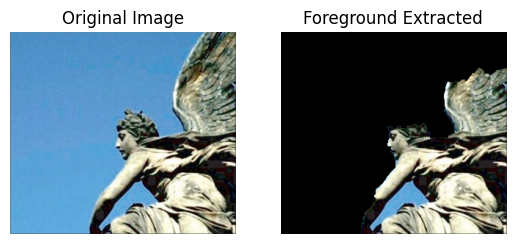

In [15]:
# Plot the results
plt.subplot(1, 2, 1)
plt.imshow(img_rgb)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(foreground)
plt.title('Foreground Extracted')
plt.axis('off')

plt.show()

## Image segmentation with the Watershed algorithm

The **Watershed algorithm** is a method used for **image segmentation**, which means it helps divide an image into regions based on certain properties (e.g., color, intensity).

#### 1. **Think of it Like Water Flowing in a Map:**
   Imagine an image is a topographic map, like a mountain landscape with valleys (low areas) and peaks (high areas). The valleys represent areas where the intensity (color or brightness) is low, and the peaks represent areas with high intensity.

#### 2. **Mark Valleys and Peaks:**
   - **Valleys**: Areas in the image that are dark or have less intensity.
   - **Peaks**: Areas in the image that are bright or have high intensity.

#### 3. **Flooding the Valleys:**
   Now, imagine pouring water into the valleys. The water will fill up the low areas first, and as it rises, it will start to touch the peaks.

#### 4. **Creating Barriers:**
   When water from two different valleys begins to meet (because they're filling up), a **barrier** (like a dam) is built between them to keep them separate.

#### 5. **Resulting Image Segmentation:**
   After the flooding process, the **barriers** created between different valleys will represent the boundaries of different regions in the image. These boundaries separate the image into **different segments**.

#### Example
<div style="text-align: center;">
    <img src="../../data/images/basil.jpg" width="200" height="100" alt="Segmentation Example">
</div>

#### When to Use Watershed

The **Watershed algorithm** is particularly useful when:
- You have objects in an image that are touching or very close together (like coins in a stack).
- You want to separate these objects and identify them individually.

In [16]:
# Load image
img = r.load_image('basil.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

In [17]:
# Apply Otsu's thresholding
ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)


In [18]:
# Remove noise with morphological opening
kernel = np.ones((3, 3), np.uint8)
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)


In [19]:
# Identify sure background
sure_bg = cv2.dilate(opening, kernel, iterations=3)

# Identify sure foreground using distance transform
dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
ret, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)


In [20]:
# Mark unknown regions
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg, sure_fg)


In [21]:
# Label markers
ret, markers = cv2.connectedComponents(sure_fg)

# Add 1 to ensure background is not 0
markers = markers + 1

# Mark unknown regions as 0
markers[unknown == 255] = 0


In [22]:
# Apply watershed algorithm
markers = cv2.watershed(img, markers)

# Mark boundaries in the original image
img[markers == -1] = [0, 0, 250]


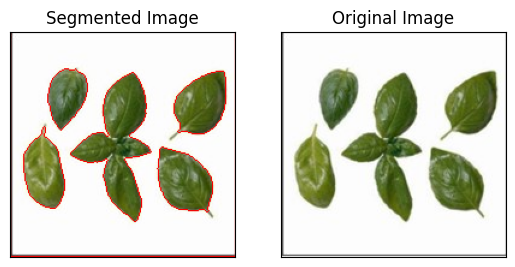

In [23]:
# Display results
plt.subplot(121), plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('Segmented Image')
plt.xticks([]), plt.yticks([])

plt.subplot(122), plt.imshow(cv2.cvtColor(r.load_image('basil.jpg'), cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.xticks([]), plt.yticks([])

plt.show()
